In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from itertools import chain
import json
import os
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np

def draw_bounding_boxes(image, labels, color=(0, 255, 0), thickness=2, text_color=(255, 255, 255)):
    for label in labels:
        # Unpack the label. Assuming label is a tuple in the form:
        # (class_name, x_center, y_center, width, height)
        class_name, x_center, y_center, width, height = label

        # Convert center coordinates to absolute coordinates
        x_center *= image.shape[1]
        y_center *= image.shape[0]
        width *= image.shape[1]
        height *= image.shape[0]

        # Calculate the top left corner (x_min, y_min) and bottom right corner (x_max, y_max)
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Draw the rectangle around the detected object
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

        # Put the class name text on the image above the bounding box
        cv2.putText(image, class_name, (x_min, y_max if y_min - 15 < 0 else y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

    return image


def get_class_name_by_id(class_id):
    class_names = {0: 'lamp', 1: 'moisture', 2: 'vent', 3: 'window'}
    return class_names.get(class_id, 'Unknown')


def process_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = get_class_name_by_id(class_id)  # Get the class name using the ID
        coords = np.array([float(x) for x in parts[1:]]).reshape(-1, 2)  
        x_min, y_min = np.min(coords, axis=0)
        x_max, y_max = np.max(coords, axis=0)
        
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        
        bbox_coords = [x_center, y_center, width, height]
        # Append a tuple of the class name and bounding box coordinates
        labels.append((class_name, *bbox_coords))  # Unpack bbox_coords into the tuple
    
    return labels


def load_and_resize(image_path, target_size=(640, 640)):
    image = cv2.imread(str(image_path))
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    return resized_image


def convert_bbox_format(bbox, from_format="YOLO", to_format="COCO"):
    """
    Convert the bounding box format from one type to another.

    YOLO format: [x_center, y_center, width, height]
    COCO format: [x_min, y_min, width, height]
    """
    if from_format == "YOLO" and to_format == "COCO":
        x_center, y_center, width, height = bbox
        x_min = x_center - (width / 2)
        y_min = y_center - (height / 2)
        return [x_min, y_min, width, height]
    elif from_format == "COCO" and to_format == "YOLO":
        x_min, y_min, width, height = bbox
        x_center = x_min + (width / 2)
        y_center = y_min + (height / 2)
        return [x_center, y_center, width, height]
    else:
        raise ValueError("Unsupported conversion format.")

def calculate_iou(bbox1, bbox2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    """
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2

    intersect_min_x = max(x1_min, x2_min)
    intersect_min_y = max(y1_min, y2_min)
    intersect_max_x = min(x1_max, x2_max)
    intersect_max_y = min(y1_max, y2_max)

    intersect_area = max(intersect_max_x - intersect_min_x, 0) * max(intersect_max_y - intersect_min_y, 0)
    
    bbox1_area = (x1_max - x1_min) * (y1_max - y1_min)
    bbox2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = bbox1_area + bbox2_area - intersect_area
    
    # compute the IoU
    iou = intersect_area / union_area if union_area != 0 else 0
    
    return iou

def non_maximum_suppression(bboxes, iou_threshold):
    """
    Perform non-maximum suppression given bounding boxes and an IoU threshold.
    """
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)  # Sort by confidence score
    nms_bboxes = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes = [box for box in bboxes if calculate_iou(chosen_box[2], box[2]) < iou_threshold]
        nms_bboxes.append(chosen_box)

    return nms_bboxes


def visualize_samples(images_dir, labels_dir, num_samples=5):
    image_paths = list(images_dir.glob('*.jpg'))
    random_sample_paths = random.sample(image_paths, num_samples)  

    for image_path in random_sample_paths:
        file_name = image_path.stem
        label_path = labels_dir / (file_name + '.txt')

        image = load_and_resize(image_path)
        labels = process_labels(label_path)
        image_with_boxes = draw_bounding_boxes(image.copy(), labels)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title('Image with Bounding Boxes')
        plt.axis('off')

        plt.show()

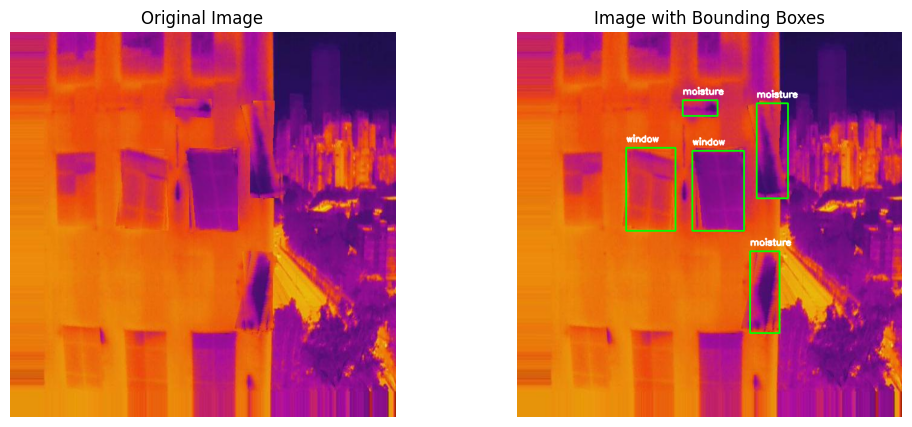

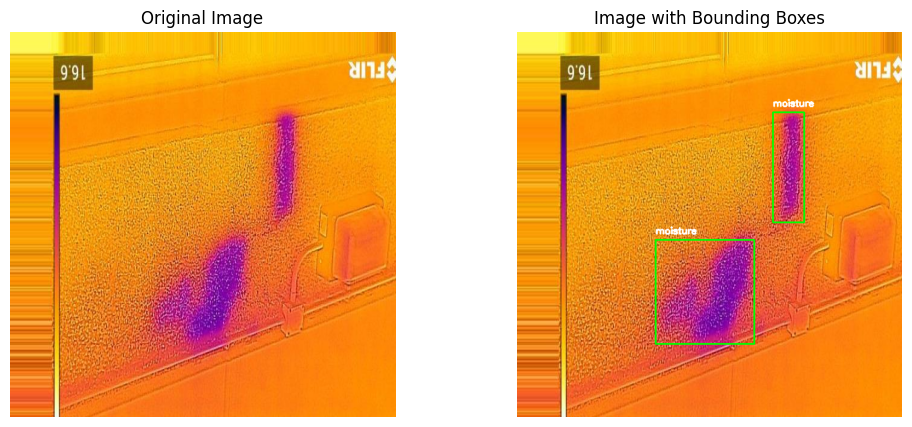

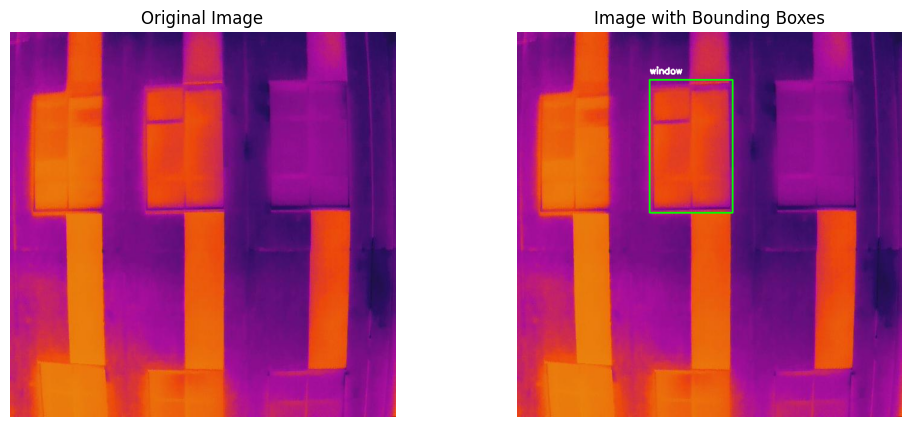

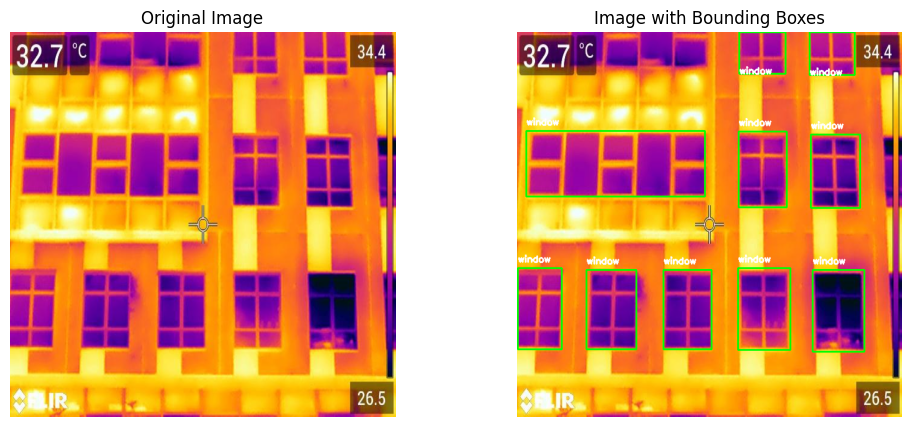

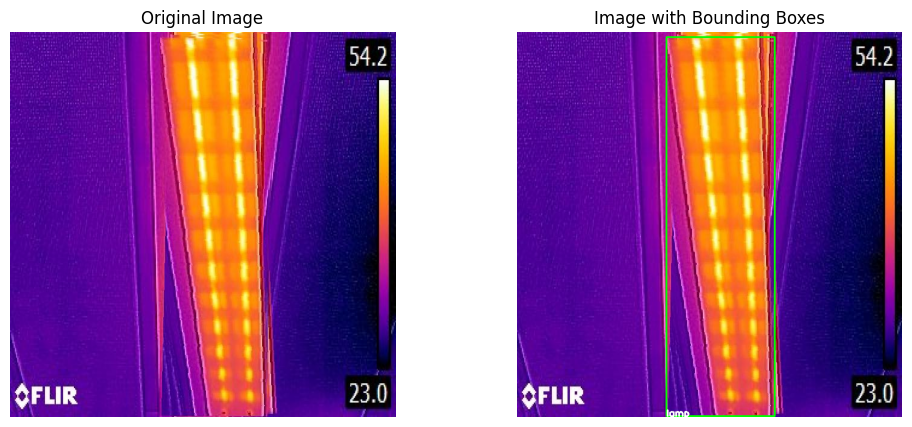

In [2]:
train_images_dir = Path('/kaggle/input/thermal-images-of-building-humidity-data-set/train/images')
train_labels_dir = Path('/kaggle/input/thermal-images-of-building-humidity-data-set/train/labels')

visualize_samples(train_images_dir, train_labels_dir, num_samples=5)

In [3]:
import shutil
import yaml

# Define the source and destination paths
src_yaml_path = '/kaggle/input/thermal-images-of-building-humidity-data-set/data.yaml'
dst_yaml_path = '/kaggle/working/data.yaml'

# Copy the file to the working directory
shutil.copy(src_yaml_path, dst_yaml_path)

# Load the YAML data
with open(dst_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Modify the train and val paths
data_yaml['train'] = '/kaggle/input/thermal-images-of-building-humidity-data-set/train/images'
data_yaml['val'] = '/kaggle/input/thermal-images-of-building-humidity-data-set/valid/images'

# Optionally, adjust the other fields if necessary
# data_yaml['nc'] = <new_number_of_classes>
# data_yaml['names'] = ['<new_class_name_1>', '<new_class_name_2>', ...]

# Save the modified YAML data back to the file in the working directory
with open(dst_yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

In [4]:
# !pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 78.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 26.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
# from pycocotools import _mask as coco_mask 
from ultralytics import YOLO


In [7]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.66 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (11028/11028), done.
/kaggle/working/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 8.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [8]:
!python /kaggle/working/yolov5/train.py --img 640 --batch 16 --epochs 50 --data /kaggle/working/data.yaml --weights yolov5s.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.co

In [9]:
# !tensorboard --logdir runs/train

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)


In [10]:
!python /kaggle/working/yolov5/detect.py --weights /kaggle/working/yolov5/runs/train/exp*/weights/best.pt --img 640 --conf 0.25 --source /kaggle/input/thermal-images-of-building-humidity-data-set/valid/images


detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/thermal-images-of-building-humidity-data-set/valid/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/119 /kaggle/input/thermal-images-of-building-humidity-data-set/valid/images/05FLIR0042_jpg.rf.54a32d2cdab0cae1865a594571406f08.jpg: 640x640 2 moistures, 6.1ms
image 2/119 /kaggle/input/thermal-images-of-building-humidity-data-set/valid/image

In [11]:
!python /kaggle/working/yolov5/val.py --weights /kaggle/working/yolov5/runs/train/exp*/weights/best.pt --data /kaggle/working/data.yaml --img 640 --iou 0.65 --half --task val --save-json


val: data=/kaggle/working/data.yaml, weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/input/thermal-images-of-building-humidity-data-set/valid/l
val: WARNING ⚠️ Cache directory /kaggle/input/thermal-images-of-building-humidity-data-set/valid is not writeable: [Errno 30] Read-only file system: '/kaggle/input/thermal-images-of-building-humidity-data-set/valid/labels.cache.npy'
                 Class     Images  Instances          P          R      mAP50   
                   all        11

In [16]:
!python /kaggle/working/yolov5/val.py --weights /kaggle/working/best.pt --data /kaggle/working/data.yaml --img 640 --iou-thres 0.5 --conf-thres 0.5 --task val --name val_results

val: data=/kaggle/working/data.yaml, weights=['/kaggle/working/best.pt'], batch_size=32, imgsz=640, conf_thres=0.5, iou_thres=0.5, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=val_results, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Traceback (most recent call last):
  File "/kaggle/working/yolov5/val.py", line 411, in <module>
    main(opt)
  File "/kaggle/working/yolov5/val.py", line 382, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/kaggle/working/yolov5/val.py", line 143, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half